In [1]:
import sys
#sys.path.remove('/usr/local/lib/python3.7/site-packages')
sys.path.append('/usr/local/.pyenv/versions/3.6.0/lib/python3.6/site-packages')
sys.path.append('/Users/kazuya_yufune/.pyenv/versions/3.6.0/lib/python3.6/site-packages')

In [2]:
from os.path import expanduser, join


import sys

import time

from nnmnkwii.datasets import FileDataSource, FileSourceDataset
from nnmnkwii.datasets import PaddedFileSourceDataset, MemoryCacheDataset  # これはなに？
from nnmnkwii.preprocessing import trim_zeros_frames, remove_zeros_frames
from nnmnkwii.preprocessing import minmax, meanvar, minmax_scale, scale
from nnmnkwii import paramgen
from nnmnkwii.io import hts
from nnmnkwii.frontend import merlin as fe
from nnmnkwii.postfilters import merlin_post_filter

from os.path import join, expanduser, basename, splitext, basename, exists
import os
from glob import glob
import numpy as np
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
import pyworld
import pysptk
import librosa
import librosa.display
import IPython
from IPython.display import Audio

import matplotlib.pyplot as plt

/usr/local/Caskroom/miniconda/base/envs/tutorial_saru/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/tutorial_saru/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [3]:
DATA_ROOT = "./data/basic5000"  # NIT-ATR503/"#
test_size = 0.01  # This means 480 utterances for training data
random_state = 1234


mgc_dim = 180  # メルケプストラム次数　？？
lf0_dim = 3  # 対数fo　？？ なんで次元が３？
vuv_dim = 1  # 無声or 有声フラグ　？？
bap_dim = 15  # 発話ごと非周期成分　？？

duration_linguistic_dim = 438  # question_jp.hed で、ラベルに対する言語特徴量をルールベースで記述してる
acoustic_linguisic_dim = 442  # 上のやつ+frame_features とは？？
duration_dim = 1
acoustic_dim = mgc_dim + lf0_dim + vuv_dim + bap_dim  # aoustice modelで求めたいもの

fs = 48000
frame_period = 5
fftlen = pyworld.get_cheaptrick_fft_size(fs)
alpha = pysptk.util.mcepalpha(fs)
hop_length = int(0.001 * frame_period * fs)

mgc_start_idx = 0
lf0_start_idx = 180
vuv_start_idx = 183
bap_start_idx = 184

windows = [
    (0, 0, np.array([1.0])),
    (1, 1, np.array([-0.5, 0.0, 0.5])),
    (1, 1, np.array([1.0, -2.0, 1.0])),
]

use_phone_alignment = True
acoustic_subphone_features = "coarse_coding" if use_phone_alignment else "full"  # とは？


from models import BinaryFileSource


X = {"acoustic": {}}
Y = {"acoustic": {}}
utt_lengths = {"acoustic": {}}
for ty in ["acoustic"]:
    for phase in ["train", "test"]:
        train = phase == "train"
        x_dim = duration_linguistic_dim if ty == "duration" else acoustic_linguisic_dim
        y_dim = duration_dim if ty == "duration" else acoustic_dim
        X[ty][phase] = FileSourceDataset(
            BinaryFileSource(join(DATA_ROOT, "X_{}".format(ty)), dim=x_dim, train=train)
        )
        Y[ty][phase] = FileSourceDataset(
            BinaryFileSource(join(DATA_ROOT, "Y_{}".format(ty)), dim=y_dim, train=train)
        )
        utt_lengths[ty][phase] = np.array([len(x) for x in X[ty][phase]], dtype=np.int)

"""
ここでH/L ラベルをつける処理
"""

X_min = {}
X_max = {}
Y_mean = {}
Y_var = {}
Y_scale = {}

for typ in ["acoustic"]:
    X_min[typ], X_max[typ] = minmax(X[typ]["train"], utt_lengths[typ]["train"])
    Y_mean[typ], Y_var[typ] = meanvar(Y[typ]["train"], utt_lengths[typ]["train"])
    Y_scale[typ] = np.sqrt(Y_var[typ])


from torch.utils import data as data_utils


import torch
from torch import nn
from torch.autograd import Variable
from tqdm import tnrange, tqdm
from torch import optim
import torch.nn.functional as F

In [4]:
class Rnn(nn.Module):
    def __init__(self, bidirectional=True, num_layers=2):
        super(Rnn, self).__init__()
        self.num_layers = num_layers
        self.num_direction = 2 if bidirectional else 1
        ##ここまでエンコーダ

        self.fc11 = nn.Linear(acoustic_linguisic_dim+1, acoustic_linguisic_dim+1)

        self.lstm2 = nn.LSTM(
            acoustic_linguisic_dim+1, 400, num_layers, bidirectional=bidirectional
        )
        self.fc3 = nn.Linear(self.num_direction * 400, acoustic_dim)

    def decode(self, linguistic_features):
        x = self.fc11(linguistic_features.view(linguistic_features.size()[0], 1, -1))
        x = F.relu(x)
        h3, (h, c) = self.lstm2(x)
        h3 = F.relu(h3)

        return self.fc3(h3)  # torch.sigmoid(self.fc3(h3))

    def forward(self, linguistic_features):

        return self.decode(linguistic_features)

In [5]:
h_l_labels_train = []
h_l_labels_test = []
for i in range(5000):
    h_l_label = np.loadtxt("./data/basic5000/accents/accents_" + "0" * (4 - len(str(i + 1))) + str(i + 1) + ".csv",)
    if i % 20 == 0:
        h_l_labels_test.append(h_l_label)
    elif (i - 1) % 20 != 0:
        h_l_labels_train.append(h_l_label)

In [6]:
X_acoustic_train = [
    minmax_scale(x, X_min["acoustic"], X_max["acoustic"], feature_range=(0.01, 0.99))
    for x in X["acoustic"]["train"]
]
Y_acoustic_train = [y for y in Y["acoustic"]["train"]]


X_acoustic_test = [
    minmax_scale(x, X_min["acoustic"], X_max["acoustic"], feature_range=(0.01, 0.99))
    for x in X["acoustic"]["test"]
]
Y_acoustic_test = [y for y in Y["acoustic"]["test"]]


train_loader = [
    [x, y, l_h_label]
    for x, y, l_h_label in zip(X_acoustic_train, Y_acoustic_train, h_l_labels_train)
]
test_loader = [
    [x, y, l_h_label]
    for x, y, l_h_label in zip(X_acoustic_test, Y_acoustic_test, h_l_labels_test)
]

mora_index_lists = sorted(glob(join("data/basic5000/mora_index", "squeezed_*.csv")))
mora_index_lists_for_model = [np.loadtxt(path).reshape(-1) for path in mora_index_lists]
train_mora_index_lists = []
test_mora_index_lists = []
test_not_valid = []

for i, mora_i in enumerate(mora_index_lists_for_model):
    if (i - 1) % 20 == 0:  # test
        pass
    elif i % 20 == 0:  # valid
        test_mora_index_lists.append(mora_i)
    else:
        train_mora_index_lists.append(mora_i)

In [7]:
model = Rnn()
model.load_state_dict(torch.load('baseline/baseline2_15.oth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
def recon(index, model=model):
    with torch.no_grad():
        tmp = []
        data = test_loader[index]
        for j in range(3):
            tmp.append(torch.from_numpy(data[j]).to(device))
        
        
        h_l_label_tensor = torch.tensor([0] * data[0].shape[0]).to(device)
        for j, mora_i in enumerate(test_mora_index_lists[index]):
            prev_index = 0 if j == 0 else int(test_mora_index_lists[index][j - 1])
            h_l_label_tensor[prev_index : int(mora_i)] = tmp[2][j]
        print(h_l_label_tensor)
            
        x = torch.cat([tmp[0].float(), h_l_label_tensor.float().view(-1, 1)], dim=1)
        
        y = model(x)
        
    return y

In [10]:
def gen_parameters(y_predicted):
    # Number of time frames
    T = y_predicted.shape[0]
    
    # Split acoustic features
    mgc = y_predicted[:,:lf0_start_idx]
    lf0 = y_predicted[:,lf0_start_idx:vuv_start_idx]
    plt.plot(lf0[:, 0])
    plt.show()
    #lf0 = Y['acoustic']['train'][90][:, lf0_start_idx:vuv_start_idx]
    #lf0 = np.zeros(lf0.shape)
    vuv = y_predicted[:,vuv_start_idx]

    plt.show()
    bap = y_predicted[:,bap_start_idx:]
    
    # Perform MLPG
    ty = "acoustic"
    mgc_variances = np.tile(Y_var[ty][:lf0_start_idx], (T, 1))#np.tile(np.ones(Y_var[ty][:lf0_start_idx].shape), (T, 1))#
    mgc = paramgen.mlpg(mgc, mgc_variances, windows)
    lf0_variances = np.tile(Y_var[ty][lf0_start_idx:vuv_start_idx], (T,1))#np.tile(np.ones(Y_var[ty][lf0_start_idx:vuv_start_idx].shape), (T,1))#
    lf0 = paramgen.mlpg(lf0, lf0_variances, windows)
    bap_variances = np.tile(Y_var[ty][bap_start_idx:], (T, 1))#np.tile(np.ones(Y_var[ty][bap_start_idx:].shape), (T, 1))#
    bap = paramgen.mlpg(bap, bap_variances, windows)
    
    return mgc, lf0, vuv, bap
def gen_waveform(y_predicted, do_postfilter=False):  
    y_predicted = trim_zeros_frames(y_predicted)
        
    # Generate parameters and split streams
    mgc, lf0, vuv, bap = gen_parameters(y_predicted)
    
    if do_postfilter:
        mgc = merlin_post_filter(mgc, alpha)
        
    spectrogram = pysptk.mc2sp(mgc, fftlen=fftlen, alpha=alpha)
    aperiodicity = pyworld.decode_aperiodicity(bap.astype(np.float64), fs, fftlen)
    f0 = lf0.copy()
    f0[vuv < 0.5] = 0
    f0[np.nonzero(f0)] = np.exp(f0[np.nonzero(f0)])
    
    generated_waveform = pyworld.synthesize(f0.flatten().astype(np.float64),
                                            spectrogram.astype(np.float64),
                                            aperiodicity.astype(np.float64),
                                            fs, frame_period)
    return generated_waveform

In [11]:
def synthesize(index, model=model):
    y = recon(index, model=model)
    IPython.display.display(Audio(gen_waveform(y.view(-1, 199).detach().numpy(), True), rate=fs))

In [12]:
def rmse(A, B) :
    return np.sqrt((np.square(A - B)).mean())

def calc_lf0_rmse(natural, generated, lf0_idx=lf0_start_idx, vuv_idx=vuv_start_idx):
    idx = (natural[:, vuv_idx] * (generated[:, vuv_idx] >= 0.5)).astype(bool)
    return rmse(natural[idx, lf0_idx], generated[idx, lf0_idx]) * 1200 / np.log(2)  # unit: [cent]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

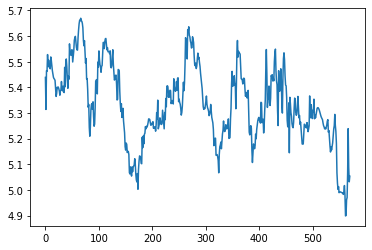

In [13]:
synthesize(2)

In [60]:
f0_error = 0
for i in tqdm(range(len(X['acoustic']['test']))):
    y = recon(i).view(-1, 199).numpy()
    y_true = Y['acoustic']['test'][i]
    f0_error += calc_lf0_rmse(y, y_true)

100%|██████████| 250/250 [03:39<00:00,  1.14it/s]


In [62]:
f0_error / 250

353.757436968724

In [17]:

class MyRNN(nn.Module):
    def __init__(self, D_in, H, D_out, num_layers=1, bidirectional=True):
        super(MyRNN, self).__init__()
        self.hidden_dim = H
        self.num_layers = num_layers
        self.num_direction =  2 if bidirectional else 1
        self.lstm = nn.LSTM(D_in, H, num_layers, bidirectional=bidirectional, batch_first=True)
        self.hidden2out = nn.Linear(self.num_direction*self.hidden_dim, D_out)
        
    def init_hidden(self, batch_size):
        h, c = (Variable(torch.zeros(self.num_layers * self.num_direction, batch_size, self.hidden_dim)), 
                Variable(torch.zeros(self.num_layers * self.num_direction, batch_size, self.hidden_dim)))
        return h,c

    def forward(self, sequence):
        h, c = self.init_hidden(1)
        output, (h, c) = self.lstm(sequence.view(1, -1, 535), (h, c))
        output = self.hidden2out(output)
        return output

In [18]:
num_hidden_layers = 3
hidden_size = 512
batch_size = 8
n_workers = 2
pin_memory = True
nepoch = 25
lr = 0.002
weight_decay = 1e-6
use_cuda = torch.cuda.is_available()
print(use_cuda)
model_no_fc = MyRNN(X['acoustic']["train"][0].shape[-1],
                            hidden_size, Y['acoustic']["train"][0].shape[-1],
                            num_hidden_layers, bidirectional=True)
model_no_fc.load_state_dict(torch.load('speechsynthesis_models/acoustic_state_dict', map_location=torch.device('cpu') ))

False


RuntimeError: Error(s) in loading state_dict for MyRNN:
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([2048, 535]) from checkpoint, the shape in current model is torch.Size([2048, 442]).
	size mismatch for lstm.weight_ih_l0_reverse: copying a param with shape torch.Size([2048, 535]) from checkpoint, the shape in current model is torch.Size([2048, 442]).

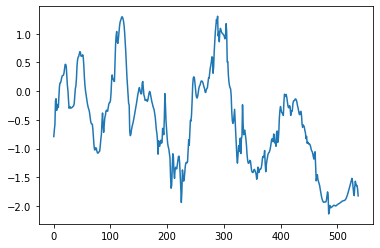

In [53]:
synthesize(0, model=model_no_fc)